## Emotional Detection ##

In [3]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG  

import tensorflow as tf
print("TensorFlow version:", tf.__version__)  


ModuleNotFoundError: No module named 'numpy.linalg'

## Exploring Datasets ##

In [5]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize = (12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));
    plt.axis('off')

NameError: name 'glob' is not defined

## Preparing Data For Training ##

In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(
    "train/",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

datagen_validation = ImageDataGenerator()

validation_generator = datagen_train.flow_from_directory(
    "test/",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Defining Model ##

In [138]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Dense, Flatten, Input
from tensorflow.keras.models import Model

# Define convolution block
def convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)  
    x = Dropout(0.25)(x)
    return x

# Define dense block
def dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

# Define model function
def model_fer(input_shape):
    inputs = Input(input_shape)
    
    # Apply convolution blocks
    conv_1 = convolution(inputs, 32, (3, 3))
    conv_2 = convolution(conv_1, 64, (5, 5))  
    conv_3 = convolution(conv_2, 128, (3, 3))
    
    # Flatten and dense layers
    flatten = Flatten()(conv_3)
    dense_1 = dense_f(flatten, 256)
    
    # Output layer
    output = Dense(7, activation="softmax")(dense_1)  
    
    # Create model
    model = Model(inputs=[inputs], outputs=[output])
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# Instantiate and summarize the model
model = model_fer((48, 48, 1))
model.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)       

## initalizing the Model ##

In [101]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generators (ensure grayscale images)
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "train/", 
    target_size=(48, 48), 
    color_mode="grayscale",  # Ensure grayscale input
    batch_size=64, 
    class_mode="categorical"
)

validation_generator = validation_datagen.flow_from_directory(
    "test/", 
    target_size=(48, 48), 
    color_mode="grayscale",  # Ensure grayscale input
    batch_size=64, 
    class_mode="categorical"
)

# Define hyperparameters
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

# Define the checkpoint callback to save model weights
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', save_weights_only=True, mode="max", verbose=1)

# Create a callbacks list with the checkpoint callback
callbacks = [checkpoint]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)



Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.7265 - accuracy: 0.3397
Epoch 00001: saving model to model_weights.h5
448/448 [==============================] - 1382s 3s/step - loss: 1.7265 - accuracy: 0.3397 - val_loss: 1.7651 - val_accuracy: 0.3414
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.4460 - accuracy: 0.4460
Epoch 00002: saving model to model_weights.h5
448/448 [==============================] - 1071s 2s/step - loss: 1.4460 - accuracy: 0.4460 - val_loss: 1.4404 - val_accuracy: 0.4551
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.3294 - accuracy: 0.4959
Epoch 00003: saving model to model_weights.h5
448/448 [==============================] - 1036s 2s/step - loss: 1.3294 - accuracy: 0.4959 - val_loss: 1.2889 - val_accuracy: 0.5006
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.2670 - accuracy: 0

## Model Evaluation ##

In [103]:
model.evaluate(validation_generator)

113/113 [==============================] - 74s 656ms/step - loss: 1.0912 - accuracy: 0.5946


[1.0911916494369507, 0.5945945978164673]

## Plotting Loss ##

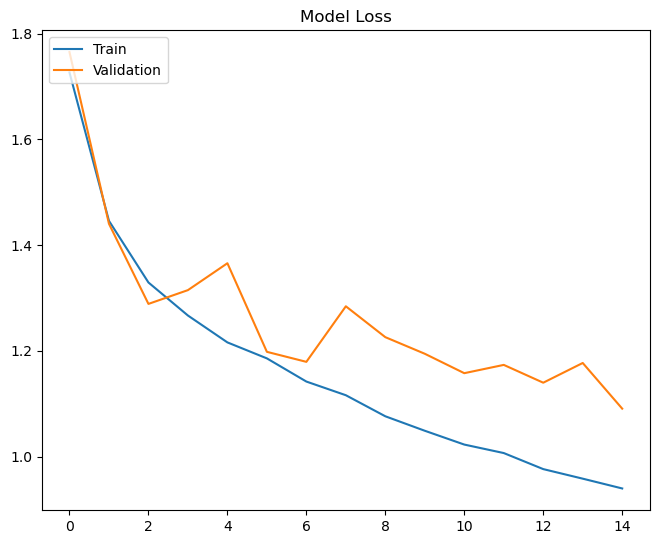

In [113]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc="upper left")

# Correcting subplots_adjust syntax and adding missing parentheses
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

plt.show()


## Model Accuracy ##

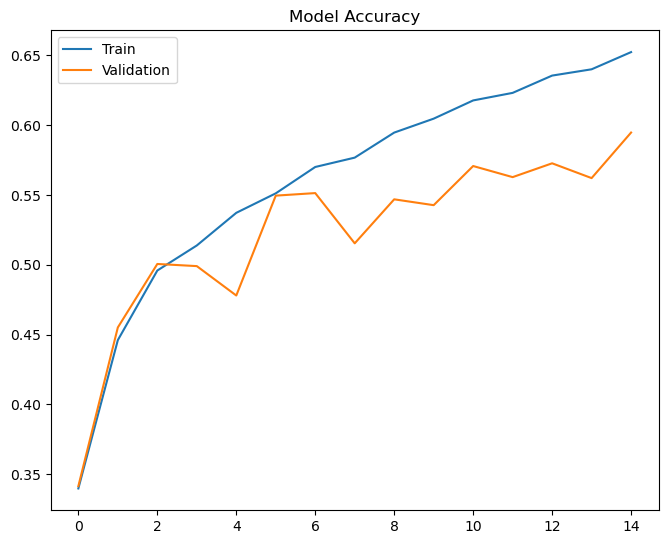

In [141]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc="upper left")

# Correcting subplots_adjust syntax and adding missing parentheses
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

plt.show()


In [124]:
## Saving model in Json File ##

In [130]:
# Save the model architecture as JSON
model_json = model.to_json()

# Write the JSON to a file
with open("model_a.json", "w") as json_file:
    json_file.write(model_json)
